# Intelligent Control and Fault Diagnosis
### Homework 2
### RBF Neural Networks
### Quad car suspensions

In [11]:
import numpy as np
import matplotlib.pyplot as plt



## Define MLP

In [12]:
class MultilayerPerceptron:
    def __init__(self, input_size, hidden_layer_sizes, output_size, activation_functions_type):
        self.input_size = input_size
        self.hidden_layer_sizes = hidden_layer_sizes
        self.output_size = output_size
        self.af_type = activation_functions_type
        self.layers = len(hidden_layer_sizes) + 1

        # Initialize weights and biases for each layer
        self.weights = [np.random.random((input_size, hidden_layer_sizes[0])).astype(np.float64)]
        self.biases = [np.random.random((1, hidden_layer_sizes[0])).astype(np.float64)]

        for i in range(1, self.layers-1):
            self.weights.append(np.random.random((hidden_layer_sizes[i - 1], hidden_layer_sizes[i])).astype(np.float64))
            self.biases.append(np.random.random((1, hidden_layer_sizes[i])).astype(np.float64))
        self.weights.append(np.random.random((hidden_layer_sizes[self.layers-2], output_size)).astype(np.float64))
        self.biases.append(np.random.random((1, output_size)).astype(np.float64))

    def activation_function(self, x, type='sigmoid'):
        if type == 'sigmoid':
            return 2 / (1 + np.exp(-x)) - 1
        elif type == 'linear':
            return x
        elif type == 'ReLU':
            return np.maximum(0, x)

    def activation_function_derivative(self, x, type='sigmoid'):
        if type == 'sigmoid':
            return (1 - self.activation_function(x, type='sigmoid') ** 2) / 2
        elif type == 'linear':
            return 1
        elif type == 'ReLU':
            return np.where(x <= 0, 0, 1)

    def forward(self, x):
        layer_output = x
        for i in range(self.layers):
            layer_input = layer_output @ self.weights[i] + self.biases[i]
            layer_output = self.activation_function(layer_input, self.af_type[i])
        return layer_output

    def gradient_calculation(self, x, e, Ac):
        layer_outputs = [x]
        layer_inputs = []

        # Forward pass
        for i in range(self.layers):
            layer_input = layer_outputs[i] @ self.weights[i] + self.biases[i]
            layer_inputs.append(layer_input)
            layer_output = self.activation_function(layer_input, self.af_type[i])
            layer_outputs.append(layer_output)

        # Backpropagation
        error = e - layer_output  # Direct error calculation
        delta = error * self.activation_function_derivative(layer_inputs[-1], self.af_type[-1])
        grads = [{'weights': 0, 'bias': 0} for _ in range(self.layers)]

        for i in range(self.layers - 1, -1, -1):
            grads[i]['weights'] = np.sum(np.expand_dims(delta, 1) * np.expand_dims(layer_outputs[i], 2), 0)
            grads[i]['bias'] = np.sum(delta, axis=0, keepdims=True)
            if i > 0:
                error = delta @ self.weights[i].T
                delta = error * self.activation_function_derivative(layer_inputs[i - 1], self.af_type[i - 1])
        return grads

    def train(self, x, e, Ac, update_step_num=10, learning_rate=0.001):
        for i in range(update_step_num):
            grads = self.gradient_calculation(x, e, Ac)
            for j in range(self.layers):
                self.weights[j] += learning_rate * grads[j]['weights']
                self.biases[j] += learning_rate * grads[j]['bias']




## Define dynamics of nonlinear system

In [13]:
class SuspensionSystem:
    def __init__(self, dt=0.01):
        self.dt = dt
        self.t = np.linspace(0, 10, int((50 - 0) / dt))
        
        # Suspension system parameters (nonlinear)
        self.ms = 290  # Sprung mass (kg)
        self.mu = 40   # Unsprung mass (kg)
        self.ks = 23500  # Linear spring stiffness (N/m)
        self.ksnl = 100 * self.ks  # Nonlinear spring stiffness (N/m^3)
        self.cs = 700   # Damping coefficient (N.s/m)
        self.kt = 190000  # Linear tire stiffness (N/m)
        self.ktnl = 1.5 * self.kt  # Nonlinear tire stiffness (N/m^2)
        self.ct = 3100    # Tire damping coefficient (N.s/m)
        
        # Initial conditions
        self.x1 = 0  # Sprung mass displacement (scalar)
        self.x2 = 0  # Unsprung mass displacement (scalar)
        self.v1 = 0  # Sprung mass velocity (scalar)
        self.v2 = 0  # Unsprung mass velocity (scalar)
        
        # Road input (sinusoidal)
        self.w = 0.05 * np.sin(2 * np.pi * self.t / 0.36)  # Road height (array)
        
        # Define Ac matrix (state-space matrix)
        self.Ac = np.eye(4)  # Identity matrix for simplicity

    def dynamics(self, u, w):
        # Suspension system dynamics equations (nonlinear)
        x1_dot = self.v1
        x2_dot = self.v2
        
        # Nonlinear spring and damping forces
        Fs = self.ks * (self.x1 - self.x2) + self.cs * (self.v1 - self.v2) + self.ksnl * (self.x1 - self.x2) ** 3
        Ft = self.kt * (self.x2 - w) + self.ct * (self.v2 - 0) + self.ktnl * (self.x2 - w) ** 2  # Assuming road velocity is 0
        
        # Accelerations of sprung and unsprung masses
        v1_dot = (-Fs + u) / self.ms
        v2_dot = (Fs - Ft) / self.mu
        
        return x1_dot, x2_dot, v1_dot, v2_dot

    def step(self, u, w):
        x1_dot, x2_dot, v1_dot, v2_dot = self.dynamics(u, w)
        
        # Update states
        self.x1 += x1_dot * self.dt
        self.x2 += x2_dot * self.dt
        self.v1 += v1_dot * self.dt
        self.v2 += v2_dot * self.dt



## Simulation

In [14]:
# Create suspension system and neural network
suspension = SuspensionSystem()
hidden_layer_sizes = [32, 32]  # 2 hidden layers with 32 neurons each
activation_functions_type = ['ReLU', 'ReLU', 'linear']  # Activation functions
mlp = MultilayerPerceptron(input_size=4, hidden_layer_sizes=hidden_layer_sizes, output_size=1, activation_functions_type=activation_functions_type)

# Simulation
history = {'x1': [], 'x2': [], 'v1': [], 'v2': [], 'u': []}
for i in range(len(suspension.t)):
    # Current system state
    xc = np.array([[suspension.x1, suspension.x2, suspension.v1, suspension.v2]])
    
    # Error (difference between current state and desired state)
    e = np.array([[0 - suspension.x1]])  # Goal: reduce oscillations (single output)
    
    # Neural network controller
    u = mlp.forward(xc)
    
    # Step the suspension system with the current road height
    suspension.step(u[0, 0], suspension.w[i])
    
    # Save history
    history['x1'].append(suspension.x1)
    history['x2'].append(suspension.x2)
    history['v1'].append(suspension.v1)
    history['v2'].append(suspension.v2)
    history['u'].append(u[0, 0])
    
    # Train the neural network
    mlp.train(xc, e, suspension.Ac, update_step_num=50, learning_rate=0.1)



## Visualization tracking

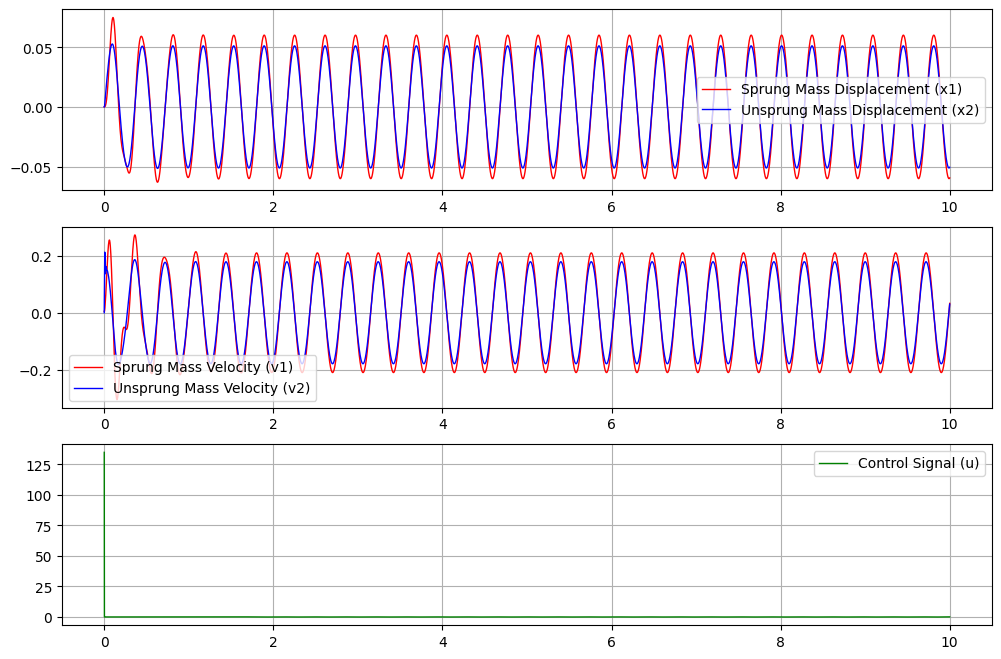

In [15]:
# Plot results
plt.figure(figsize=(12, 8))

plt.subplot(3,1,1)
plt.plot(suspension.t, history['x1'], 'r-', label='Sprung Mass Displacement (x1)', linewidth=1)
plt.plot(suspension.t, history['x2'], 'b-', label='Unsprung Mass Displacement (x2)', linewidth=1)
plt.grid('on')
plt.legend()

plt.subplot(3,1,2)
plt.plot(suspension.t, history['v1'], 'r-', label='Sprung Mass Velocity (v1)', linewidth=1)
plt.plot(suspension.t, history['v2'], 'b-', label='Unsprung Mass Velocity (v2)', linewidth=1)
plt.grid('on')
plt.legend()

plt.subplot(3,1,3)
plt.plot(suspension.t, history['u'], 'g-', label='Control Signal (u)', linewidth=1)
plt.grid('on')
plt.legend()

plt.show()